In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score

from sklearn.base import BaseEstimator, TransformerMixin

In [103]:
from tensorflow.keras import Model
from tensorflow.keras import metrics
from tensorflow.keras import Input
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.optimizers import SGD

from tensorflow.keras.regularizers import l1
from tensorflow.keras.regularizers import l2

from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [5]:
from lib.pyimagesearch import LearningRateFinder
from lib.clr_callback import CyclicLR

In [12]:
import stanza

In [6]:
from sentence_transformers import SentenceTransformer

In [20]:
from sklearn.base import BaseEstimator, TransformerMixin

In [7]:
dfTrain = pd.read_csv('../Data/train.csv', encoding = 'utf-8', lineterminator="\n")

In [8]:
model = SentenceTransformer('all-MiniLM-L6-v2')

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [11]:
dfTrain.iloc[1]

id                                                        85aa80a4c
url_legal                                                       NaN
license                                                         NaN
excerpt           All through dinner time, Mrs. Fayre was somewh...
target                                                    -0.315372
standard_error                                             0.480805
Name: 1, dtype: object

In [13]:
nlp = stanza.Pipeline('en', logging_level='WARN', processors='tokenize,pos,constituency, sentiment')

In [18]:
class embedderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        
    def fit(self, X, y = None):
        return self
    def transform(self, X, y=None):
        return self

In [31]:
from sklearn.preprocessing import FunctionTransformer
transformer = FunctionTransformer(model.encode)

In [69]:
excerpts = transformer.transform(dfTrain['excerpt'])

In [101]:
len(excerpts)

2834

In [110]:
dev_X = excerpts

dev_y = dfTrain['target']

In [98]:
dev_x

array([[-0.02262075,  0.14137919,  0.03077401, ..., -0.01153027,
        -0.15841153,  0.00094017],
       [-0.09760334,  0.02328159,  0.06266468, ...,  0.08901526,
         0.03988856, -0.06141273],
       [-0.07508896,  0.03696774,  0.07279821, ...,  0.00823782,
        -0.00522678, -0.01391408],
       ...,
       [-0.0217931 ,  0.02609281, -0.01499768, ...,  0.05362114,
         0.04901458,  0.05105647],
       [-0.06112657,  0.09415562,  0.09584144, ...,  0.02447426,
        -0.04785219, -0.00624868],
       [-0.08208136,  0.04205007,  0.0609734 , ...,  0.0610136 ,
        -0.0248262 , -0.02747508]], dtype=float32)

In [95]:
inputs = Input(shape=(384,))
x = Dense(384, activation="relu")(x)
outputs = Dense(1, activation="sigmoid")(x)
dense_model = Model(inputs, outputs)

dense_model.compile(optimizer=SGD(learning_rate=0.001), loss="binary_crossentropy", metrics=["acc"])

In [96]:
dense_history = dense_model.fit(dev_x, dev_y, epochs=10, batch_size=32, validation_split=0.25, verbose=0)

<AxesSubplot:>

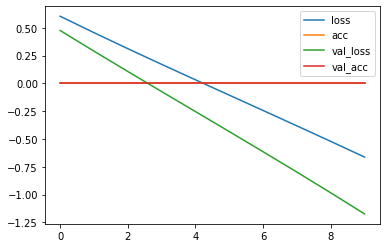

In [97]:
pd.DataFrame(dense_history.history).plot()

In [111]:
inputs = Input(shape=(384,))
x = Embedding(input_dim=2834, input_length=384, output_dim=384)(inputs)
x = SimpleRNN(384, activation="tanh", return_sequences=True)(x)
outputs = Dense(1, activation="sigmoid")(x)
rnn = Model(inputs, outputs)

rnn.compile(optimizer=SGD(learning_rate=0.01), loss="binary_crossentropy", metrics=["acc"])

In [112]:
rnn.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 384)]             0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 384, 384)          1088256   
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 384, 384)          295296    
_________________________________________________________________
dense_12 (Dense)             (None, 384, 1)            385       
Total params: 1,383,937
Trainable params: 1,383,937
Non-trainable params: 0
_________________________________________________________________


In [113]:
rnn_history = rnn.fit(dev_x, dev_y, epochs=10, batch_size=32, validation_split=0.25, 
                      callbacks=[EarlyStopping(monitor="val_loss", patience=2)], verbose=0)

<AxesSubplot:>

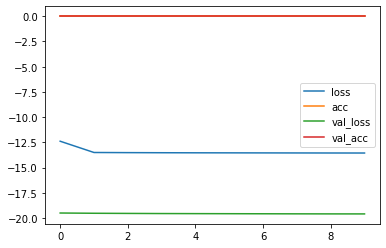

In [114]:
pd.DataFrame(rnn_history.history).plot()